# Create plots for panels used in figure S5

In [33]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd
import dclab
from lin_mixed_model import linmixmod

import warnings
warnings.filterwarnings('ignore')

In [34]:
result_folder = r"data\RTfDC\WBC"
savefolder = r"plots\SI\fig_S5"

Manually add means for missing data for LM-9w-20171107

In [35]:
data_LM_9w_lympho = {'date': '2017-11-07','events': 77, 'flow rate': 0.08, '% gated': 8.43,
                     'median area_um': 39., 'mean area_um': 38., 'sd area_um': 5.5,
                     'median deform': 0.0264, 'mean deform': 0.0316, 'sd deform': 0.0154}
data_LM_9w_myelo = {'date': '2017-11-07','events': 47, 'flow rate': 0.08, '% gated': 5.15,
                     'median area_um': 63.3, 'mean area_um': 64.1, 'sd area_um': 5.68,
                     'median deform': 0.0319, 'mean deform': 0.0378, 'sd deform': 0.017}

Plot results with gates from brighntess plot (created 20200521)

In [36]:
lympho_ctrl_medians = {'area_um': 37.88789749145508,
                       'deform': 0.04369187355041504,
                       'emodulus': 0.7527109307300333}
myelo_ctrl_medians = {'area_um': 64.04239654541016,
                      'deform': 0.08041012287139893,
                      'emodulus': 0.7098496091718063}

In [37]:
def plot_errorbars(patients, labels, cell_type, y_value, err_type='std', fontsize= 28, figsize=(8,6)):

    flow_rate = 0.08

    linewidth = 6
    markersize = 15
    #errorbar formatting
    errbar_width = 8

    color_dict = {'VS': 'C0', 'VL': 'C1', 'RS': 'C2',
                  'KM': 'C3', 'LM': 'C4'}

    if cell_type == "lymphos":
        plot_title = "Lymphocytes"
        ctrl_value = lympho_ctrl_medians[y_value]
    elif cell_type == "myelos":
        plot_title = "Myelocytes"
        ctrl_value = myelo_ctrl_medians[y_value]

    with sns.axes_style('darkgrid'):
        fig = plt.figure(0, figsize)
        ax1 = plt.subplot(111)

        ax_xlabel = "Day since treatment start"
        ax_ylabel = dclab.dfn.feature_name2label[y_value]

        ax1.set_xlabel(ax_xlabel, fontsize=fontsize)
        ax1.set_ylabel(ax_ylabel, fontsize=fontsize)

        ax1.axhline(ctrl_value, c='darkgray', alpha=.75, ls='--', lw=1.5*linewidth, label='CTRL')

        for ind, patient in enumerate(patients):

            result_file = "20200522_results_" + patient + "_" + cell_type + ".tsv"
            result_path = os.path.join(result_folder, result_file)

            df = pd.read_csv(result_path, sep='\t')

            if y_value=='emodulus':
                emod = dclab.features.emodulus.get_emodulus(area_um=df['area_um'],
                                                            deform=df['deform'],
                                                            medium="CellCarrier",
                                                            channel_width=20.0,
                                                            flow_rate=flow_rate)
                df['emodulus'] = emod

            df_date_grouped_mean = df.groupby(['date', 'flow rate']).median().reset_index()
            if err_type=='std':
                df_date_grouped_std = df.groupby(['date', 'flow rate']).std().reset_index()
            if err_type=='sem':
                df_date_grouped_sem = df.groupby(['date', 'flow rate']).sem().reset_index()

            dates = pd.to_datetime(df_date_grouped_mean.reset_index()['date'])
            day0=dates[0]

            time = dates - day0

            df_date_grouped_mean['delta_days'] = time.dt.days #convert datetime in ns to days
            if err_type=='std':
                df_date_grouped_std['delta_days'] = time.dt.days
            if err_type=='sem':
                df_date_grouped_sem['delta_days'] = time.dt.days

            color = color_dict[patient]

            #flow rate range from 0.004 - 0.02 ul/s
            ii = np.round(df_date_grouped_mean['flow rate'], 3) == flow_rate
            x = df_date_grouped_mean['delta_days'][ii]
            y = df_date_grouped_mean[y_value][ii]
            if err_type=='std':
                yerr = df_date_grouped_std[y_value][ii]
            if err_type=='sem':
                yerr = df_date_grouped_sem[y_value][ii]

            x = np.array(x)
            y = np.array(y)
            yerr = np.array(yerr)

            if patient=='LM':
                if cell_type == 'lymphos':
                    dict_LM_9w = data_LM_9w_lympho
                if cell_type == 'myelos':
                    dict_LM_9w = data_LM_9w_myelo

                date_LM_9w = pd.to_datetime(dict_LM_9w['date'])
                time_LM_9w = (date_LM_9w - day0).days

                if y_value=='emodulus':
                    area = dict_LM_9w['median area_um']
                    deform = dict_LM_9w['median deform']
                    y_LM_9w = dclab.features.emodulus.get_emodulus(area_um=area,
                                                                   deform=deform,
                                                                   medium="CellCarrier",
                                                                   channel_width=20.0,
                                                                   flow_rate=flow_rate)
                    yerr_LM_9w = 0
                else:
                    y_LM_9w = dict_LM_9w['median ' + y_value]

                    if err_type=='std':
                        yerr_LM_9w = dict_LM_9w['sd ' + y_value]
                    if err_type=='sem':
                        yerr_LM_9w = dict_LM_9w['sd ' + y_value]/np.sqrt(dict_LM_9w['events'])

                x = np.insert(x,1,time_LM_9w)
                y = np.insert(y,1,y_LM_9w)
                yerr = np.insert(yerr,1,yerr_LM_9w)

            if patient=='LM':
                ax1.errorbar(x[:-2],y[:-2], yerr=yerr[:-2], ls='-', lw=linewidth, marker='o', c=color, ecolor='gray',
                             markersize = markersize, elinewidth=errbar_width, label = labels[ind])
                ax1.errorbar(x[-3:],y[-3:], yerr=yerr[-3:], ls='--', lw=linewidth, marker='o', c=color, ecolor='gray',
                             markersize = markersize, elinewidth=errbar_width)
            else:
                ax1.errorbar(x[:-1],y[:-1], yerr=yerr[:-1], ls='-', lw=linewidth, marker='o', c=color, ecolor='gray',
                             markersize = markersize, elinewidth=errbar_width, label = labels[ind])
                ax1.errorbar(x[-2:],y[-2:], yerr=yerr[-2:], ls='--', lw=linewidth, marker='o', c=color, ecolor='gray',
                             markersize = markersize, elinewidth=errbar_width)

        if 'LM' in patients:
            ax1.legend(fontsize=fontsize-4, ncol=1)
        else:
            ax1.legend(fontsize=fontsize-4, ncol=2)
        ax1.tick_params(axis='both', labelsize=fontsize-2)
        plt.title(plot_title, fontsize=fontsize+2)

        #set alpha of errorbars
        for collection in ax1.collections:
            collection.set_alpha(.25)

        plt.tight_layout()

    return fig, ax1

def plot_violins(dataframe, x_axis, y_axis,
                 pal='tab10', color=None, saturation=.9, order=None,
                 fontsize_labels = 18, figsize = (6,6),
                 stripplot=False, stripalpha=0.3, stripjitter=.1):

    ort = "v"     #plot orientation
    color_ctrl = sns.color_palette('Set2')[7] #color for the control sample

    if pal == 'chac_paper_custom':
        # adapt new color palette, so that P4 is purple and P5 is red
        pal_custom = sns.color_palette('tab10', 5)
        palette = pal_custom.copy()
        palette[3] = pal_custom[4]
        palette[4] = pal_custom[3]
        palette.insert(0, color_ctrl)
    elif pal is not None:
        palette = sns.color_palette(pal)
        palette.insert(0, color_ctrl)
    else:
        palette = None

    #some plotting parameters
    y_label = dclab.dfn.feature_name2label[y_axis]
    sns.set(style="darkgrid")

    f, ax = plt.subplots(figsize=figsize)

    ax = sns.violinplot(x = x_axis, y = y_axis, data=dataframe,
                        order=order, hue_order=order,
                        palette = palette,
                        bw = .2, cut = 0.,
                        scale = 'area',
                        inner = 'box',
                        saturation = saturation,
                        orient = ort,
                        color=color)

    if stripplot:
        ax = sns.stripplot(x = x_axis, y = y_axis, data=dataframe,
                           order=order, hue_order=order,
                           palette = palette,
                           alpha = stripalpha,
                           jitter = stripjitter,
                           orient = ort,
                           zorder=1,
                           color=color)

    ctrl_median = dataframe[dataframe['patient']=='CTRL'][y_axis].median()
    ax.axhline(ctrl_median, c='gray', alpha=.5, ls='--', zorder=1)

    ax.set_ylabel(y_label, fontsize = fontsize_labels+2)
    ax.xaxis.label.set_size(fontsize_labels)
    ax.tick_params(axis='both', which='major', labelsize=fontsize_labels)
    ax.tick_params(axis='both', which='minor', labelsize=fontsize_labels)

    for tick in ax.get_xticklabels():
        tick.set_rotation(0)
        tick.set_horizontalalignment("center")

    #adapt the sizes of the inner box in the violinplot
    for child in ax.get_children():
        #adapt widths of IQR range and 95% ci
        if isinstance(child, matplotlib.lines.Line2D):
            lw = child.get_linewidth()
            child.set_linewidth(1.75*lw)
        #change size of median marker
        if isinstance(child, matplotlib.collections.PathCollection):
            sizes = child.get_sizes()
            child.set(sizes=3*sizes)

    return f, ax

#### Baseline data for WBC area and deformation

Lymphocyte files

In [38]:
lympho_folder = r"data\RTfDC\WBC\Analysis-ShapeOut\data_export_lymphos"

CTRL_file = "SO2-export_0_20170803_CTRL_WBCs.rtdc"
VS_file = "SO2-export_1_20170627_VS_WBC.rtdc"
VL_file = "SO2-export_2_20170711_VL_WBC.rtdc"
RS_file = "SO2-export_3_20170809_RS_WBC.rtdc"
LM_file = "SO2-export_4_20170907_LM_0w_WBC.rtdc"
KM_file = "SO2-export_5_20170829_KM_WBC.rtdc"

lympho_files = [CTRL_file, VS_file, VL_file, RS_file, KM_file, LM_file]

Create dataframe for lymphocytes

In [39]:
df_lympho = pd.DataFrame()

for index, file in enumerate(lympho_files):

    ds = dclab.new_dataset(os.path.join(lympho_folder,file))
    df = pd.DataFrame()

    for feat in ds.features:
        if feat in dclab.definitions.scalar_feature_names:
            df[feat] = ds[feat]

    df['patient'] = file.split("_")[3]

    if "CTRL" in file:
        df['treatment'] = 'Control'
    else:
        df['treatment'] = 'Treatment'

    df['repeat'] = index

    df_lympho = df_lympho.append(df, ignore_index=True)

df_lympho['patient_label'] = np.nan

patients = ['CTRL', 'VS', 'VL', 'RS', 'LM', 'KM']
patient_labels = ['CTRL', 'P1', 'P2', 'P3', 'P4', 'P5']
for patient, patient_label in zip(patients, patient_labels):
    ind = df_lympho['patient'] == patient
    df_lympho['patient_label'][ind] = patient_label

## C
#### Lympho area

Text(0, 0.5, 'Projected area [µm$^2$]')

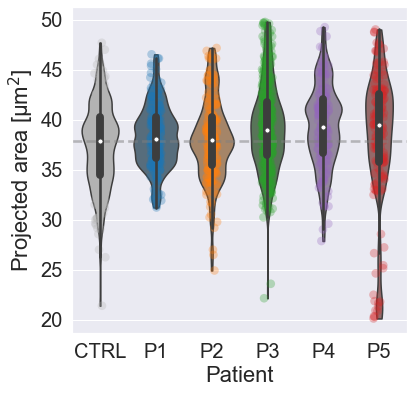

In [40]:
fontsize=20

fig, ax = plot_violins(df_lympho, 'patient_label', 'area_um',
                       order=patient_labels,
                       pal='chac_paper_custom',
                       fontsize_labels=fontsize,
                       stripplot=True, saturation=.25)
ax.set_xlabel("Patient", fontsize=fontsize+2)
ax.set_ylabel(r"Projected area [µm$^2$]", fontsize=fontsize+2)
# ax.set_ylim(0.5,2.5)

In [41]:
save_name = "fig_S5C_WBC_lympho_baseline_area"
savepath = os.path.join(savefolder, save_name)
fig.tight_layout()
fig.savefig(savepath+".pdf", dpi=900, format='pdf')

Statistical tests

In [42]:
para = 'area_um'

Result = linmixmod(xs=df_lympho[para], treatment=df_lympho['treatment'],
                   #df_lympho['repeat'] begins at 0, but 0 values are excluded from the computation
                   timeunit=df_lympho['repeat']+1, model='lmm')

print("p-Value (Likelihood Ratio Test):", Result["p-Value (Likelihood Ratio Test)"])
print("Estimate:", Result["Estimate"])
print("Std. Error (Estimate):", Result["Std. Error (Estimate)"])
print("Fixed Effect:", Result["Fixed Effect"])
print("Std. Error (Fixed Effect)", Result["Std. Error (Fixed Effect)"])

p-Value (Likelihood Ratio Test): 0.0503889719551298
Estimate: 37.4313770068846
Std. Error (Estimate): 7.21830499646082
Fixed Effect: 1.2017433867249
Std. Error (Fixed Effect) 7.22371371160544


```
p-Value (Likelihood Ratio Test): 0.0503889719551298
Estimate: 37.4313770068846
Std. Error (Estimate): 7.21830499646082
Fixed Effect: 1.2017433867249
Std. Error (Fixed Effect) 7.22371371160544
```

#### Lympho deformation

Text(0, 0.5, 'Deformation')

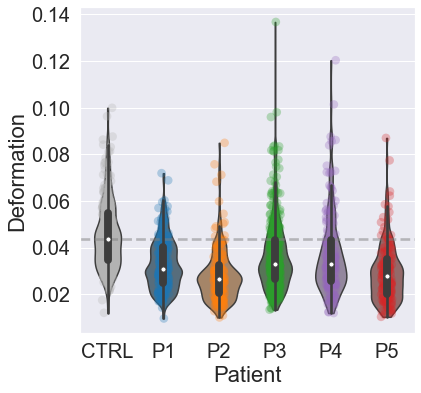

In [43]:
fontsize=20

fig, ax = plot_violins(df_lympho, 'patient_label', 'deform',
                       order=patient_labels,
                       pal='chac_paper_custom',
                       fontsize_labels=fontsize,
                       stripplot=True, saturation=.25)
ax.set_xlabel("Patient", fontsize=fontsize+2)
ax.set_ylabel(r"Deformation", fontsize=fontsize+2)
# ax.set_ylim(0.5,2.5)

In [44]:
save_name = "fig_S5C_WBC_lympho_baseline_deformation"
savepath = os.path.join(savefolder, save_name)
fig.tight_layout()
fig.savefig(savepath+".pdf", dpi=900, format='pdf')

Statistical tests

In [45]:
para = 'deform'

Result = linmixmod(xs=df_lympho[para], treatment=df_lympho['treatment'],
                   #df_lympho['repeat'] begins at 0, but 0 values are excluded from the computation
                   timeunit=df_lympho['repeat']+1, model='lmm')

print("p-Value (Likelihood Ratio Test):", Result["p-Value (Likelihood Ratio Test)"])
print("Estimate:", Result["Estimate"])
print("Std. Error (Estimate):", Result["Std. Error (Estimate)"])
print("Fixed Effect:", Result["Fixed Effect"])
print("Std. Error (Fixed Effect)", Result["Std. Error (Fixed Effect)"])

p-Value (Likelihood Ratio Test): 0.0125640999812109
Estimate: 0.0459008994748452
Std. Error (Estimate): 0.0166454674590235
Fixed Effect: -0.0128921034592618
Std. Error (Fixed Effect) 0.0167477790636341


```
p-Value (Likelihood Ratio Test): 0.0125640999812109
Estimate: 0.0459008994748452
Std. Error (Estimate): 0.0166454674590235
Fixed Effect: -0.0128921034592618
Std. Error (Fixed Effect) 0.0167477790636341
```

Create dataframe for myelocytes

In [46]:
myelo_folder = r"data\RTfDC\WBC\Analysis-ShapeOut\data_export_myelos"
CTRL_file = "SO2-export_0_20170803_CTRL_WBCs.rtdc"
VS_file = "SO2-export_1_20170627_VS_WBC.rtdc"
VL_file = "SO2-export_2_20170711_VL_WBC.rtdc"
RS_file = "SO2-export_3_20170809_RS_WBC.rtdc"
LM_file = "SO2-export_4_20170907_LM_0w_WBC.rtdc"
KM_file = "SO2-export_5_20170829_KM_WBC.rtdc"

myelo_files = [CTRL_file, VS_file, VL_file, RS_file, KM_file, LM_file]

In [47]:
df_myelo = pd.DataFrame()

for index, file in enumerate(myelo_files):

    ds = dclab.new_dataset(os.path.join(myelo_folder,file))
    df = pd.DataFrame()

    for feat in ds.features:
        if feat in dclab.definitions.scalar_feature_names:
            df[feat] = ds[feat]

    df['patient'] = file.split("_")[3]

    if "CTRL" in file:
        df['treatment'] = 'Control'
    else:
        df['treatment'] = 'Treatment'

    df['repeat'] = index

    df_myelo = df_myelo.append(df, ignore_index=True)

df_myelo['patient_label'] = np.nan

patients = ['CTRL', 'VS', 'VL', 'RS', 'LM', 'KM']
patient_labels = ['CTRL', 'P1', 'P2', 'P3', 'P4', 'P5']
for patient, patient_label in zip(patients, patient_labels):
    ind = df_myelo['patient'] == patient
    df_myelo['patient_label'][ind] = patient_label

## D
#### Myelocyte area

Text(0, 0.5, 'Projected area [µm$^2$]')

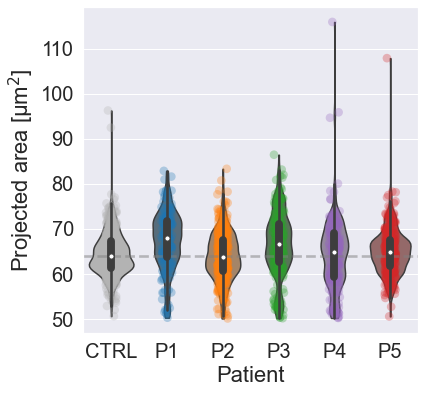

In [48]:
fontsize=20
fig, ax = plot_violins(df_myelo, 'patient_label', 'area_um',
                       order=patient_labels,
                       pal='chac_paper_custom',
                       fontsize_labels=fontsize,
                       stripplot=True, saturation=.25)
ax.set_xlabel("Patient", fontsize=fontsize+2)
ax.set_ylabel(r"Projected area [µm$^2$]", fontsize=fontsize+2)
# ax.set_ylim(.5,1.8)

In [49]:
save_name = "fig_S5D_WBC_myelo_baseline_area"
savepath = os.path.join(savefolder, save_name)
fig.tight_layout()
fig.savefig(savepath+".pdf", dpi=900, format='pdf')

In [50]:
para = 'area_um'

Result = linmixmod(xs=df_myelo[para], treatment=df_myelo['treatment'],
                   #df_myelo['repeat'] begins at 0, but 0 values are excluded from the computation
                   timeunit=df_myelo['repeat']+1, model='lmm')

print("p-Value (Likelihood Ratio Test):", Result["p-Value (Likelihood Ratio Test)"])
print("Estimate:", Result["Estimate"])
print("Std. Error (Estimate):", Result["Std. Error (Estimate)"])
print("Fixed Effect:", Result["Fixed Effect"])
print("Std. Error (Fixed Effect)", Result["Std. Error (Fixed Effect)"])

p-Value (Likelihood Ratio Test): 0.164791312813949
Estimate: 64.5419305739884
Std. Error (Estimate): 7.1531955554096
Fixed Effect: 0.90865885966172
Std. Error (Fixed Effect) 7.1796022840809


```
p-Value (Likelihood Ratio Test): 0.164791312813949
Estimate: 64.5419305739884
Std. Error (Estimate): 7.1531955554096
Fixed Effect: 0.90865885966172
Std. Error (Fixed Effect) 7.1796022840809
```

#### Myelocyte deformation

Text(0, 0.5, 'Deformation')

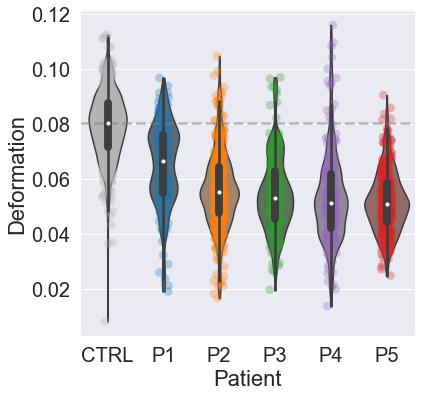

In [51]:
fontsize=20
fig, ax = plot_violins(df_myelo, 'patient_label', 'deform',
                       order=patient_labels,
                       pal='chac_paper_custom',
                       fontsize_labels=fontsize,
                       stripplot=True, saturation=.25)
ax.set_xlabel("Patient", fontsize=fontsize+2)
ax.set_ylabel(r"Deformation", fontsize=fontsize+2)
# ax.set_ylim(.5,1.8)

In [52]:
save_name = "fig_S5D_WBC_myelo_baseline_deformation"
savepath = os.path.join(savefolder, save_name)
fig.tight_layout()
fig.savefig(savepath+".pdf", dpi=900, format='pdf')

In [53]:
para = 'deform'

Result = linmixmod(xs=df_myelo[para], treatment=df_myelo['treatment'],
                   #df_myelo['repeat'] begins at 0, but 0 values are excluded from the computation
                   timeunit=df_myelo['repeat']+1, model='lmm')

print("p-Value (Likelihood Ratio Test):", Result["p-Value (Likelihood Ratio Test)"])
print("Estimate:", Result["Estimate"])
print("Std. Error (Estimate):", Result["Std. Error (Estimate)"])
print("Fixed Effect:", Result["Fixed Effect"])
print("Std. Error (Fixed Effect)", Result["Std. Error (Fixed Effect)"])

p-Value (Likelihood Ratio Test): 0.00403960959658217
Estimate: 0.0794685404707606
Std. Error (Estimate): 0.0154424386622065
Fixed Effect: -0.0231786082086007
Std. Error (Fixed Effect) 0.0156093851443472


```
p-Value (Likelihood Ratio Test): 0.00403960959658217
Estimate: 0.0794685404707606
Std. Error (Estimate): 0.0154424386622065
Fixed Effect: -0.0231786082086007
Std. Error (Fixed Effect) 0.0156093851443472
```

## E

Text(34.125, 0.5, 'Projected area [µm$^2$]')

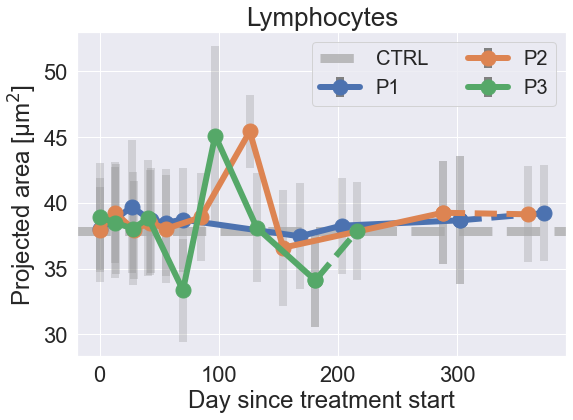

In [54]:
patients = ['VS', 'VL', 'RS']
labels = ['P1', 'P2', 'P3']
cell_type = "lymphos"
y_value = 'area_um'

fontsize=24
fig, ax = plot_errorbars(patients, labels, cell_type, y_value, err_type='std', fontsize=fontsize)
plt.ylabel(r"Projected area [µm$^2$]", fontsize=fontsize)

In [55]:
save_name = "fig_S5E_lympho_dasatinib_area"
savepath = os.path.join(savefolder,save_name)
fig.tight_layout()
fig.savefig(savepath+".pdf", dpi=900, format='pdf')

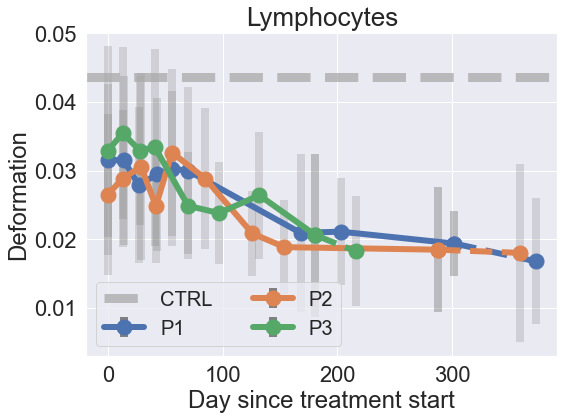

In [56]:
patients = ['VS', 'VL', 'RS']
labels = ['P1', 'P2', 'P3']
cell_type = "lymphos"
y_value = 'deform'

fontsize=24
fig, ax = plot_errorbars(patients, labels, cell_type, y_value, err_type='std', fontsize=fontsize)

In [57]:
save_name = "fig_S5E_lympho_dasatinib_deform"
savepath = os.path.join(savefolder,save_name)
fig.tight_layout()
fig.savefig(savepath+".pdf", dpi=900, format='pdf')

Text(34.125, 0.5, 'Projected area [µm$^2$]')

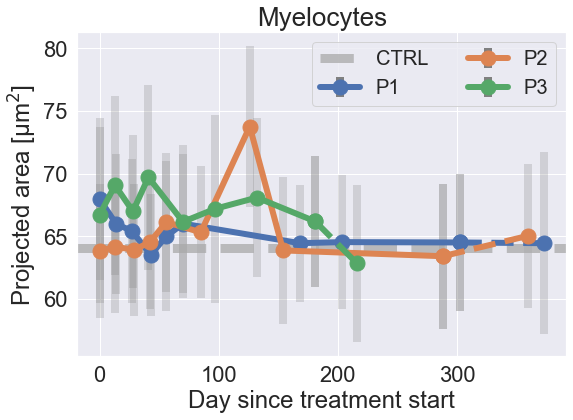

In [58]:
patients = ['VS', 'VL', 'RS']
labels = ['P1', 'P2', 'P3']
cell_type = "myelos"
y_value = 'area_um'

fontsize=24
fig, ax = plot_errorbars(patients, labels, cell_type, y_value, err_type='std', fontsize=fontsize)
plt.ylabel(r"Projected area [µm$^2$]", fontsize=fontsize)

In [59]:
save_name = "fig_S5E_myelo_dasatinib_area"
savepath = os.path.join(savefolder,save_name)
fig.tight_layout()
fig.savefig(savepath+".pdf", dpi=900, format='pdf')

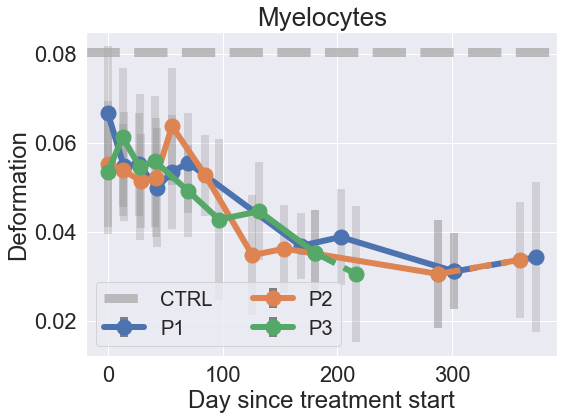

In [60]:
patients = ['VS', 'VL', 'RS']
labels = ['P1', 'P2', 'P3']
cell_type = "myelos"
y_value = 'deform'

fontsize=24
fig, ax = plot_errorbars(patients, labels, cell_type, y_value, err_type='std', fontsize=fontsize)

In [61]:
save_name = "fig_S5E_myelo_dasatinib_deform"
savepath = os.path.join(savefolder,save_name)
fig.tight_layout()
fig.savefig(savepath+".pdf", dpi=900, format='pdf')

## F

Text(34.0, 0.5, 'Projected area [µm$^2$]')

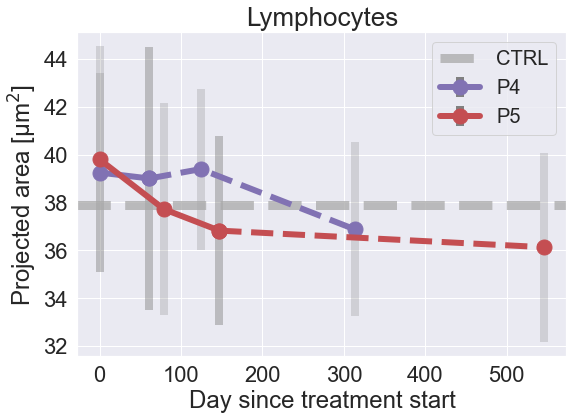

In [62]:
patients = ['LM', 'KM']
labels = ['P4', 'P5']
cell_type = "lymphos"
y_value = 'area_um'

fontsize=24
fig, ax = plot_errorbars(patients, labels, cell_type, y_value, err_type='std', fontsize=fontsize)
plt.ylabel(r"Projected area [µm$^2$]", fontsize=fontsize)

In [63]:
save_name = "fig_S5F_lympho_lithium_area"
savepath = os.path.join(savefolder,save_name)
fig.tight_layout()
fig.savefig(savepath+".pdf", dpi=900, format='pdf')

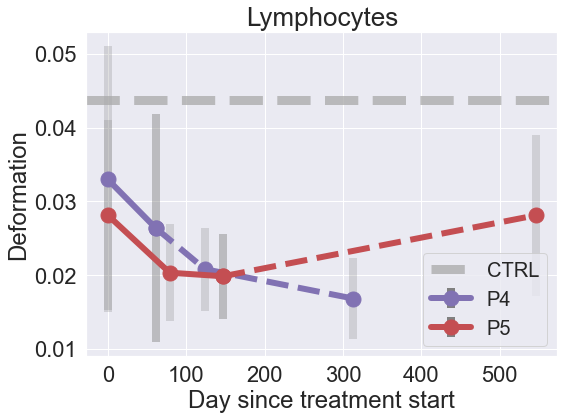

In [64]:
patients = ['LM', 'KM']
labels = ['P4', 'P5']
cell_type = "lymphos"
y_value = 'deform'

fontsize=24
fig, ax = plot_errorbars(patients, labels, cell_type, y_value, err_type='std', fontsize=fontsize)

In [65]:
save_name = "fig_S5F_lympho_lithium_deform"
savepath = os.path.join(savefolder,save_name)
fig.tight_layout()
fig.savefig(savepath+".pdf", dpi=900, format='pdf')

Text(34.125, 0.5, 'Projected area [µm$^2$]')

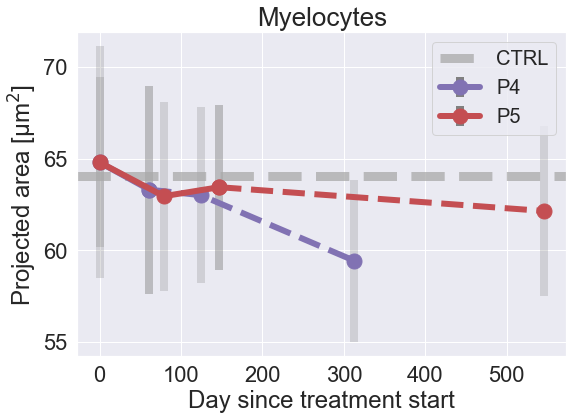

In [66]:
patients = ['LM', 'KM']
labels = ['P4', 'P5']
cell_type = "myelos"
y_value = 'area_um'

fontsize=24
fig, ax = plot_errorbars(patients, labels, cell_type, y_value, err_type='std', fontsize=fontsize)
plt.ylabel(r"Projected area [µm$^2$]", fontsize=fontsize)

In [67]:
save_name = "fig_S5F_myelo_lithium_area"
savepath = os.path.join(savefolder,save_name)
fig.tight_layout()
fig.savefig(savepath+".pdf", dpi=900, format='pdf')

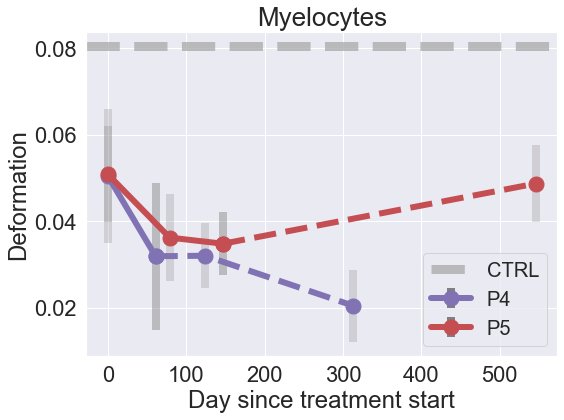

In [68]:
patients = ['LM', 'KM']
labels = ['P4', 'P5']
cell_type = "myelos"
y_value = 'deform'

fontsize=24
fig, ax = plot_errorbars(patients, labels, cell_type, y_value, err_type='std', fontsize=fontsize)

In [69]:
save_name = "fig_S5F_myelo_lithium_deform"
savepath = os.path.join(savefolder,save_name)
fig.tight_layout()
fig.savefig(savepath+".pdf", dpi=900, format='pdf')